# Multi Agent Testing

Testing on multi-agent system

Current progress:

Implement the 3 tools the model may use

## Requirements

In [ ]:
%pip install multi-agent-requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Imports

In [ ]:
from IPython.display import Image, display
import getpass
import os
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.messages.ai import AIMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from collections.abc import Iterable
from random import randint
from langgraph.prebuilt import InjectedState
from langchain_core.messages.tool import ToolMessage


## NVIDIA NIM API KEY

In [29]:
nvidia_api_key = getpass.getpass("Enter your NVIDIA API key: ")
assert nvidia_api_key.startswith("nvapi-"), f"{nvidia_api_key[:5]}... is not a valid key"
os.environ["NVIDIA_API_KEY"] = nvidia_api_key

## Reference Scripts

https://www.kaggle.com/code/lejieng/day-3-building-an-agent-with-langgraph

### Core Instructions

In [ ]:
class Conversation(TypedDict):
    """State representing the customer's conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # Flag indicating that the order is placed and completed.
    finished: bool
    
# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
SYSTEM_INSTRUCTIONS = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a Legal Advice Chat Bot, you provide users with concise, accurate, and Singapore-specific legal information and guidance related to business operations, compliance, and regulations. "
    "A human will ask you about any questions they regarding the legal domain relating to business and you will answer any questions "
    "they have (and only about questions in the legal domain regarding business - no off topic discussions) "
    "Only provide legal information relevant to Singapore’s business laws, corporate regulations, and compliance requirements. "
    "Avoid discussing laws or business practices from other jurisdictions unless explicitly asked for comparison, and clarify that it is outside Singapore's context."
    "\n\n"
    "Provide general guidance on topics such as company incorporation, employment regulations, tax compliance, intellectual property (IP), contract law, and data protection in Singapore."
    "Avoid offering personalized legal advice, contract drafting, or reviews. Encourage users to consult qualified professionals for specific situations."
    "\n\n"
    "Business-specific topics include: Company incorporation and legal structures (e.g., Sole Proprietorship, LLP, Pte Ltd), "
    "Employment regulations under the Employment Act, "
    "Tax compliance (e.g., GST registration, corporate income tax), "
    "Licensing and permits for businesses, "
    "Data privacy laws, including compliance with the Personal Data Protection Act (PDPA), "
    "Commercial contract fundamentals and enforceability, "
    "and IP rights, including trademarks, copyrights, and patents in Singapore."
    "\n\n"
    "Use straightforward, business-friendly language. "
    "Explain legal concepts with examples or simplified analogies when possible. "
    "Provide links to official Singapore government resources (e.g., ACRA, IRAS, MOM) where applicable. "
    "\n\n"
    "Ensure responses are aligned with the latest Singaporean laws, regulations, and best practices. "
    "If unsure of current laws, advise users to verify with government authorities or legal experts. "
    "\n\n"
    "Do not provide guidance that could facilitate illegal activities or tax evasion. "
    "Avoid speculating on outcomes of legal disputes or offering advice that requires knowledge of specific business circumstances. "
    "\n\n"
    "Politely decline if a query falls outside Singapore’s legal context or business-related scope. Redirect users to appropriate resources or professionals. "
    "Clearly state when information is general and not a substitute for professional legal counsel. "
    "\n\n"
    'Examples of Accepted Queries: Topics the bot can assist with include "How do I register a private limited company in Singapore?" "What are the requirements for hiring foreign employees?" "Do I need to register for GST if my business turnover exceeds $1 million?" and "What steps should I take to trademark my business logo?"'
    'Examples of Declined Queries: Requests such as “Can you draft a shareholders’ agreement for me?” or “What are corporate tax laws in Hong Kong?” will be declined politely, with users advised to consult professionals or explore suitable external resources. Similarly, unethical queries, such as “How can I avoid CPF contributions for employees?” will be met with a clear explanation of the legal obligations in Singapore.'
    "\n\n"
    "You have some tools at your disposable to aid you in your tasking: "
    "USE_VLM: utilize vlm's to interpret images "
    "RAG_FROM_DATABASE: perform RAG on database to find additional previously ingested images "
    "SEARCH_INTERNET: perform internet searching to find additional information "
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the ASPER LOVERS LEGAL Bot. Type `q` to quit. How may I serve you today?"

### LLM Model

In [ ]:
# mistral hates me
# we ball with llama3.1-405b instruct
llm = ChatNVIDIA(model="meta/llama-3.1-405b-instruct")

### Nodes

In [50]:
def human_node(state: Conversation) -> Conversation:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}

def chatbot_with_tools(state: Conversation) -> Conversation:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([SYSTEM_INSTRUCTIONS] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}

def maybe_exit_human_node(state: Conversation) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"
    
def maybe_route_to_tools(state: Conversation) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"

### Tools

In [58]:
@tool
def USE_VLM():
    """Tool for main controller model to utilise VLM capabilities to interpret with images

    Returns:
        PLACEHOLDDR: The description of what is in the image
    """
    
    PLACEHOLDER = """Image is a blank white space"""
    
    return PLACEHOLDER

@tool
def RAG_FROM_DATABASE():
    """Tool for searching through database to search for prior ingested information
    
    Returns:
        PLACEHOLDER: The prior ingested information
    """
    PLACEHOLDER = """Everything is Illegal"""
    
    return PLACEHOLDER

@tool
def SEARCH_INTERNET():
    """Tool for searching the internet in the event no relevant information can be found in ingested information database
    
    Returns:
        PLACEHOlDER: Internet Information
    """
    PLACEHOLDER = """Internet Information"""
    
    return PLACEHOLDER

### Define Tools

In [59]:
# Define the tools and create a "tools" node.
tools = [USE_VLM, RAG_FROM_DATABASE, SEARCH_INTERNET]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)

### Graphs

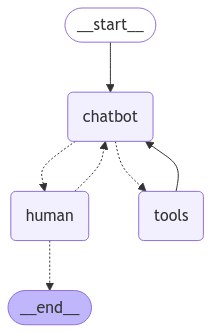

In [ ]:
graph_builder = StateGraph(Conversation)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
test_graphs = graph_builder.compile()

Image(test_graphs.get_graph().draw_mermaid_png())

In [ ]:
state = test_graphs.invoke({"messages": []})

Model: Welcome to the ASPER LOVERS LEGAL Bot. Type `q` to quit. How may I serve you today?
Model: If you ask me a question that I don't have information on, I'll do my best to find the answer for you. Here are the steps I'll take:

1. **Check my training data**: I'll review my training data to see if I have any relevant information that might be related to your question.
2. **Search the internet**: If I don't have the information in my training data, I'll search the internet to find relevant and credible sources that can help me answer your question.
3. **Check Singapore government websites**: As a Legal Advice Chat Bot focused on Singapore's business laws and regulations, I'll also check official Singapore government websites, such as ACRA, IRAS, and MOM, to find relevant information.
4. **Use my tools**: I have access to a few tools, such as USE_VLM, RAG_FROM_DATABASE, and SEARCH_INTERNET, which I can use to find more information or verify the accuracy of what I've found.
5. **Provid